In [35]:
import asyncio
import os

from dotenv import load_dotenv
from IPython.display import display, Image
from langchain.chat_models import init_chat_model
from langchain_core.messages import convert_to_messages
from langchain_tavily import TavilySearch
from langgraph.prebuilt import create_react_agent
from langgraph_supervisor import create_supervisor

In [3]:
web_search = TavilySearch(max_results=3)

### Worker agent

In [ ]:
web_search_results = web_search.invoke('Who is the mayor of NYC?')
web_search_results['results'][0]["content"]

'[Sign up](https://x.com/i/flow/signup) [](https://x.com/) [1,264 Following](https://x.com/NYCMayor/following) [1.5M Followers](https://x.com/NYCMayor/verified_followers) [Posts](https://x.com/NYCMayor?lang=en) [Replies](https://x.com/NYCMayor/with_replies?lang=en) [Highlights](https://x.com/NYCMayor/highlights?lang=en) [Media](https://x.com/NYCMayor/media?lang=en) [![Image 3](https://pbs.twimg.com/profile_images/1619354647705042946/eKfUt2ma_normal.jpg)](https://x.com/NYCMayor) [Mayor Eric Adams](https://x.com/NYCMayor) [@NYCMayor](https://x.com/NYCMayor) [14h](https://x.com/NYCMayor/status/1969860290184352089) [45K](https://x.com/NYCMayor/status/1969860290184352089/analytics) [![Image 4](https://pbs.twimg.com/profile_images/1619354647705042946/eKfUt2ma_normal.jpg)](https://x.com/NYCMayor) [Mayor Eric Adams](https://x.com/NYCMayor) [@NYCMayor](https://x.com/NYCMayor) [Jan 13, 2021](https://x.com/NYCMayor/status/1349348625663610882) [](https://x.com/NYCMayor/status/1349348625663610882/a

In [ ]:
async def build_research_system_prompt() -> str:
    return (
        "You are a research agent.\n\n"
        "INSTRUCTIONS:\n"
        "- Assist ONLY with research-related tasks, DO NOT do any math\n"
        "- After you're done with your tasks, respond to the supervisor directly\n"
        "- Respond ONLY with the results of your work, do NOT include ANY other text."
    )

In [ ]:
system_prompt = await build_research_system_prompt()

research_agent = create_react_agent(
    model=f"openai:gpt-4o",
    tools=[web_search],
    prompt=system_prompt,
    name='research_agent'
)

In [ ]:
async def pretty_print_message(message, indent=False):
    pretty_message = message.pretty_repr(html=True)
    if not indent:
        print(pretty_message)
        return
    
    indented = "\n".join("\t" + c for c in pretty_message.split('\n'))
    print(indented)
    
    
async def pretty_print_messages(update, last_message=False):
    is_subgraph = False
    if isinstance(update, tuple):
        ns, update = update
        # skip parent graph updates in the printouts
        if len(ns) == 0:
            return 
        
        graph_id = ns[-1].split(":")[0]
        print(f"Update from subgraph {graph_id}:")
        print("\n")
        is_subgraph = True
        
    for node_name, node_update in update.items():
        update_label = f"Update from node {node_name}:"
        if is_subgraph:
            update_label = "\t" + update_label
        
        print(update_label)
        print("\n")
        
        messages = convert_to_messages(node_update['messages'])
        if last_message:
            messages = messages[-1:]
            
        for m in messages:
            await pretty_print_message(m, indent=is_subgraph)
        print("\n")

In [ ]:
async for chunk in research_agent.astream(
    {"messages": [{"role": "user", "content": "Who is the mayor of NYC?"}]}
):
    await pretty_print_messages(chunk)

Update from node agent:


================================== Ai Message ==================================
Name: research_agent
Tool Calls:
  tavily_search (call_CD8OQ85uuGrTMViHgPTg3xYj)
 Call ID: call_CD8OQ85uuGrTMViHgPTg3xYj
  Args:
    query: current mayor of New York City
    search_depth: basic


Update from node tools:


================================= Tool Message =================================
Name: tavily_search

{"query": "current mayor of New York City", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.nyc.gov/mayors-office", "title": "Welcome to the Mayor's Office - NYC.gov", "content": "Mayor Eric Adams has served the people of New York City as an NYPD officer, State Senator, Brooklyn Borough President, and now as the 110th Mayor of the", "score": 0.80771893, "raw_content": null}, {"url": "https://www.cnn.com/2025/09/28/us/video/enten-nyc-mayoralrace-nr", "title": "Harry Enten breaks down the current odds for the NYC mayoral

### Math agent

In [20]:
async def add(a: float, b: float):
    """Add two numbers"""
    return a + b

async def mulitply(a: float, b: float):
    """Multiply two numbers"""
    return a * b

async def divide(a: float, b: float):
    """Divide two numbers"""
    return a / b


    

In [28]:
async def build_math_system_prompt():
    return (
        "You are a math agent.\n\n"
        "INSTRUCTIONS:\n"
        "- Assist ONLY with math-related tasks\n"
        "- After you're done with your tasks, respond to the supervisor directly\n"
        "- Respond ONLY with the results of your work, do NOT include ANY other text."
    )

In [29]:
math_system_prompt = await build_math_system_prompt()

math_agent = create_react_agent(
    model=f"openai:gpt-4o",
    tools=[add, mulitply, divide],
    prompt=math_system_prompt,
    name="math_agent"
)

In [30]:
async for chunk in math_agent.astream(
    {"messages": [{"role": "user", "content": "what's (3 + 5) x 7"}]}
):
    await pretty_print_messages(chunk)

Update from node agent:


================================== Ai Message ==================================
Name: math_agent
Tool Calls:
  add (call_mw4wG2AVMyV5Cm5NVk7Xzhxm)
 Call ID: call_mw4wG2AVMyV5Cm5NVk7Xzhxm
  Args:
    a: 3
    b: 5


Update from node tools:


================================= Tool Message =================================
Name: add

8.0


Update from node agent:


================================== Ai Message ==================================
Name: math_agent
Tool Calls:
  mulitply (call_HI2y7hL5dWNBtczYUBaRZFWe)
 Call ID: call_HI2y7hL5dWNBtczYUBaRZFWe
  Args:
    a: 8.0
    b: 7


Update from node tools:


================================= Tool Message =================================
Name: mulitply

56.0


Update from node agent:


================================== Ai Message ==================================
Name: math_agent

56.0




### Supervisor agent

In [33]:
async def build_supervisor_agent_prompt():
    return (
        "You are a supervisor managing two agents:\n"
        "- a research agent. Assign research-related tasks to this agent\n"
        "- a math agent. Assign math-related tasks to this agent\n"
        "Assign work to one agent at a time, do not call agents in parallel.\n"
        "Do not do any work yourself."
    )

In [34]:
supervisor_agent_prompt = await build_supervisor_agent_prompt()

supervisor = create_supervisor(
    model=init_chat_model("openai:gpt-4o"),
    agents=[research_agent, math_agent],
    prompt=supervisor_agent_prompt,
    add_handoff_back_messages=True,
    output_mode='full_history'
).compile()

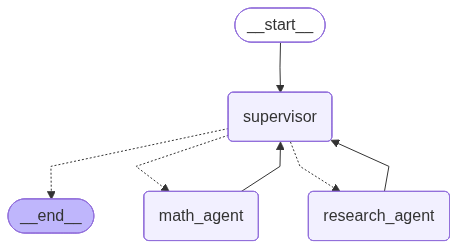

In [36]:
display(Image(supervisor.get_graph().draw_mermaid_png()))

In [38]:
async for chunk in supervisor.astream(
    {
        "messages": [
            {
                "role": "user",
                "content": "find US and New York state GDP in 2024. what % of US GDP was New York state?",
            }
        ]
    },
):
    print(chunk)
    await pretty_print_messages(chunk, last_message=True)

final_message_history = chunk["supervisor"]["messages"]

{'supervisor': {'messages': [HumanMessage(content='find US and New York state GDP in 2024. what % of US GDP was New York state?', additional_kwargs={}, response_metadata={}, id='a1d55137-ebc0-4d38-a59e-d5040fdd2ca9'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_5m6r4RDKQef5wjLcRijivVtq', 'function': {'arguments': '{}', 'name': 'transfer_to_research_agent'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 13, 'prompt_tokens': 141, 'total_tokens': 154, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_cbf1785567', 'id': 'chatcmpl-CLvohGpneV6XqrTeuQOLAcj5EDHXs', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, name='supervisor', id='run--5c98ca7b-1cc3-4400-8d38-a318fb87f2b9-0'